In [73]:
import pandas as pd
import numpy as np
import argparse
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
import scipy.stats as stats

In [74]:
# Change data paths to your own
metadata = pd.read_csv("processed_metadata.txt", sep="\t")
cluster_labels = pd.read_csv("MDS_clustering_labels_df.tsv", sep="\t")

# Choose which method to use for clustering if you df has multiple clustering method labels
cluster_labels = cluster_labels.loc[:, ["sample_id", "kmeans_cluster_label"]]

In [75]:
cluster_labels

,sample_id,kmeans_cluster_label
0,TCGA-4P-AA8J,1
1,TCGA-BA-4074,1
2,TCGA-BA-4075,0
3,TCGA-BA-4076,0
4,TCGA-BA-4077,1
...,...,...
496,TCGA-UF-A7JT,1
497,TCGA-UF-A7JV,1
498,TCGA-UP-A6WW,1
499,TCGA-WA-A7GZ,2


In [94]:
def keep_sample(x):
    parts = x.split('-')

    if len(parts) < 4:
        return True

    if parts[3].startswith("06"):
        return False

    return True


filtered_cluster_labels = cluster_labels[
    cluster_labels["sample_id"].apply(keep_sample)
].copy()


print("before filter：", cluster_labels.shape)
print("after filter：", filtered_cluster_labels.shape)


filtered_cluster_labels["patient_id"] = filtered_cluster_labels["sample_id"].apply(
    lambda x: "-".join(x.split('-')[:3])
)


filtered_cluster_labels = filtered_cluster_labels.rename(columns={"kmeans_cluster_label": "cluster"})
df = pd.merge(filtered_cluster_labels, metadata, on='patient_id', how='inner')

if "sample_id" in df.columns:
    df = df.drop(columns=["sample_id"])


before filter： (501, 2)
after filter： (501, 2)


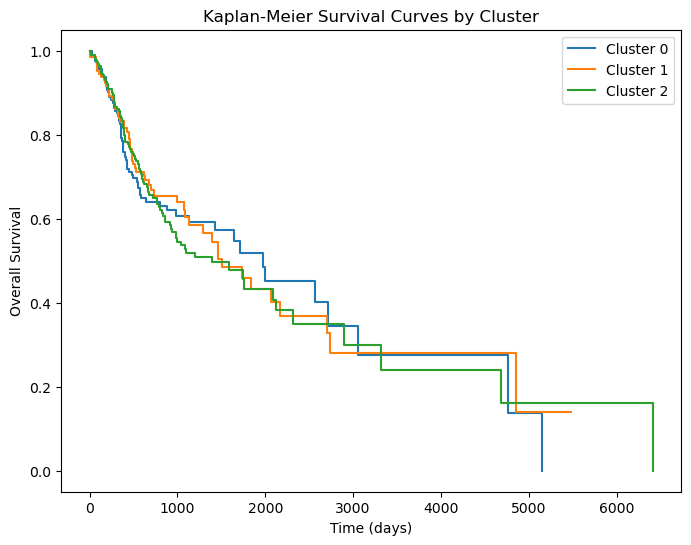

   test_statistic         p  -log2(p)
0        0.214719  0.898203  0.154887


<lifelines.CoxPHFitter: fitted with 501 total observations, 284 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 501
number of events observed = 217
   partial log-likelihood = -1182.63
         time fit was run = 2025-04-13 23:31:09 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
cluster_1 -0.04      0.96      0.18           -0.39            0.31                0.68                1.37
cluster_2  0.04      1.04      0.16           -0.28            0.36                0.76                1.43

           cmp to     z    p  -log2(p)
covariate                             
cluster_1    0.00 -0.21 0.83      0.26
cluster_2    0.00  0.25 0.80      0.32
---
Concordance = 0.51
Partial AIC = 2369.26
log-likelihood ratio test = 0.22 on 2 df
-log2(p) of ll-ratio test = 0.16

In [78]:
# -------------------------------------------------
# Kaplan-Meier Estimation and Visualization
# -------------------------------------------------
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

# Loop through each cluster, fit, and plot the survival function
for cluster, cluster_df in df.groupby('cluster'):
    kmf.fit(cluster_df['time'], event_observed=cluster_df['event'], label=f'Cluster {cluster}')
    kmf.plot_survival_function(ci_show=False)  # Plot survival function with confidence intervals

plt.title("Kaplan-Meier Survival Curves by Cluster")
plt.xlabel("Time (days)")
plt.ylabel("Overall Survival")
plt.legend()
plt.show()

# -------------------------------------------------
# Multivariate Log-Rank Test for Comparing Survival Curves
# -------------------------------------------------
# The multivariate_logrank_test function compares the survival distribution
# across all groups at once.
logrank_results = multivariate_logrank_test(df['time'], df['cluster'], event_observed=df['event'])
print(logrank_results.summary)

# -------------------------------------------------
# Cox Proportional Hazards Model for Hazard Ratios
# -------------------------------------------------
# Ensure the "cluster" column is treated as a categorical variable.
# Here we convert it to string and then create dummy variables.
df['cluster'] = df['cluster'].astype(str)
df_encoded = pd.get_dummies(df[['cluster']], drop_first=True)  # drop_first to set a reference level
df_model = pd.concat([df[['time', 'event']], df_encoded], axis=1)

cph = CoxPHFitter()
cph.fit(df_model, duration_col='time', event_col='event')
cph.print_summary()  # Displays hazard ratios, confidence intervals, and p-values


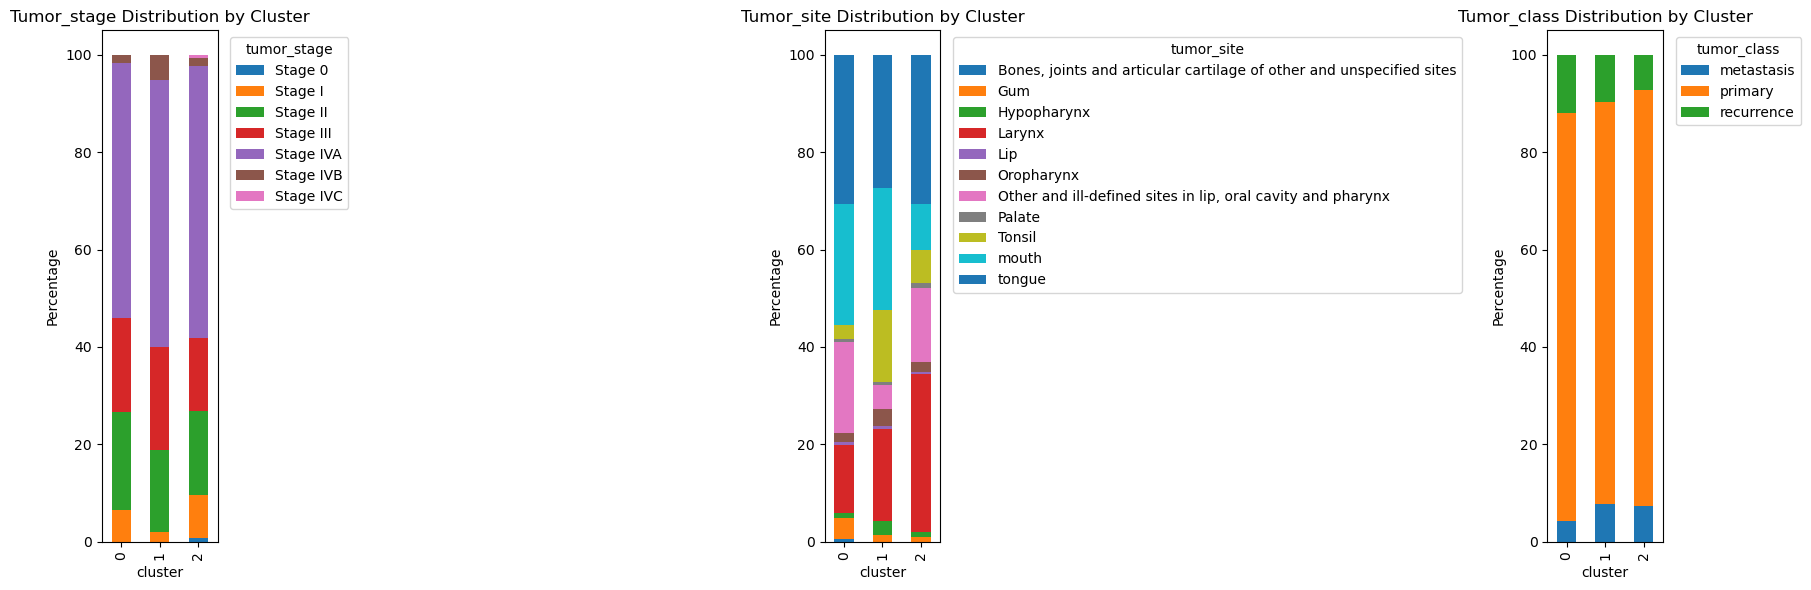

In [79]:
# ============================================================
# Creating Stacked Bar Plots for Each Categorical Variable
# ============================================================
# We will produce one stacked bar plot per variable.
# In each plot the x-axis corresponds to the groups (here: clusters)
# and the bars show the relative percentages of each category for the variable.

variables = ['tumor_stage', 'tumor_site', 'tumor_class']

# Create one subplot per variable
fig, axes = plt.subplots(1, len(variables), figsize=(6 * len(variables), 6))

# Iterate over the variables and plot each as a stacked bar chart
for ax, var in zip(axes, variables):
    # Create a contingency table of cluster vs the current variable.
    # The option normalize='index' computes the proportions within each cluster,
    # and multiplying by 100 converts those to percentages.
    ct = pd.crosstab(df['cluster'], df[var], normalize='index') * 100
    
    # Plot the stacked bar chart.
    ct.plot(kind='bar', stacked=True, ax=ax)
    
    # Set labels and title.
    ax.set_ylabel('Percentage')
    ax.set_title(f'{var.capitalize()} Distribution by Cluster')
    
    # Place the legend outside for better readability.
    ax.legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve layout so the subplots don’t overlap.
plt.tight_layout()
plt.show()

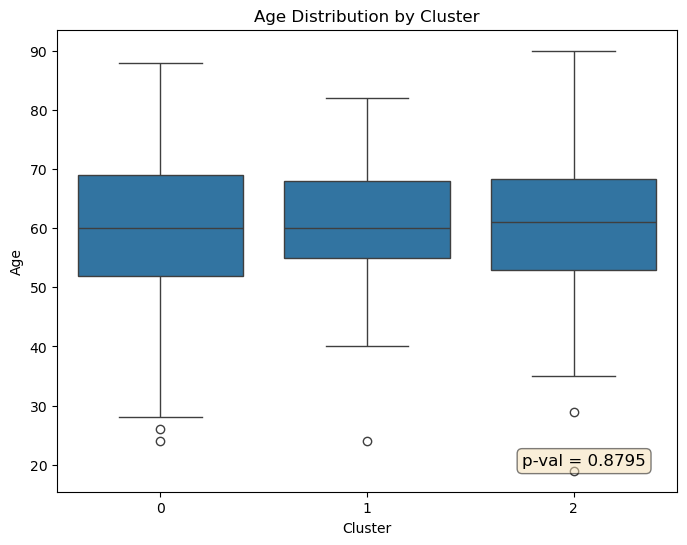

In [80]:
# ============================================================
# Create Boxplot: Age distribution by Cluster
# ============================================================
order = sorted(df['cluster'].unique())

groups = [df[df['cluster'] == cluster]['age'] for cluster in df['cluster'].unique()]
anova_result = stats.f_oneway(*groups)
p_val = anova_result.pvalue

plt.figure(figsize=(8, 6))
sns.boxplot(x='cluster', y='age', data=df, order=order)
plt.title('Age Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Age')

ax = plt.gca()
ax.text(0.95, 0.05, f"p-val = {p_val:.4f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()